In this notebook, we will set up a simple dashboard of the number of covid cases/fatalities on a county by county level. We will play with Haskell to do this, using the Frames, Foldl, and Chart libraries in iHaskell.

In [1]:
{-# LANGUAGE DataKinds, FlexibleContexts, QuasiQuotes, TemplateHaskell, TypeApplications, TypeOperators, OverloadedStrings #-}

Line 1: Unused LANGUAGE pragma
Found:
{-# LANGUAGE DataKinds, FlexibleContexts, QuasiQuotes,
  TemplateHaskell, TypeApplications, TypeOperators, OverloadedStrings
  #-}
Why not:
{-# LANGUAGE DataKinds, FlexibleContexts, TypeOperators #-}

Import the data manipulation libraries:

In [23]:
import qualified Control.Foldl as L
import qualified Data.Foldable as F
import Data.Maybe (isNothing)
import Data.Vinyl.XRec (toHKD)
import Data.Vinyl.Curry (runcurryX)
import Control.Lens hiding (Identity)
import Frames
import Data.Text (pack, unpack)

Next comes the charting library.

In [3]:
import Graphics.Rendering.Chart.Easy

Load the Data from the new-york times repository: https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv

In [4]:
tableTypes "Covid" "us-counties.csv"

In [5]:
loadCovid :: IO (Frame Covid)
loadCovid = inCoreAoS (readTable "us-counties.csv")

In [6]:
cs <- loadCovid

Let's take a quick look at the first 5 elements of data:

In [7]:
mapM_ print (take 5 (F.toList cs))

{date :-> "2020-01-21", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-22", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-23", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-24", county :-> "Cook", state :-> "Illinois", fips :-> 17031, cases :-> 1, deaths :-> 0}
{date :-> "2020-01-24", county :-> "Snohomish", state :-> "Washington", fips :-> 53061, cases :-> 1, deaths :-> 0}

Set up a filter by county.

In [8]:
countyLens countyName = (== countyName) . view county

In [9]:
countyPrefilter countyName = L.prefilter (countyLens countyName)

Next set up a fold to extract the number of cases/fatalities as a list

In [10]:
listCasesFold = L.handles cases L.list
listDeathsFold = L.handles deaths L.list

In [11]:
countyCases countyName = countyPrefilter countyName listCasesFold
countyDeaths countyName = countyPrefilter countyName listDeathsFold

This extracts the cases in Alameda county as follows:

In [12]:
L.fold (countyCases "Alameda") cs

[1,1,2,2,2,3,3,3,24,25,25,29,29,29,37,40,49,53,57,67,87,127,139,151,156,199,241,277,291,304,334,380,417,464,464,587,609,655,695,734,766,827,864,907,908,983,1069,1084,1135,1185,1212,1260,1260,1350,1422,1458,1489,1519,1554,1589,1624,1657,1726,1770,1797,1830,1884,1938,1982,2044,2085,2122,2154,2199,2202,2321,2372,2413,2478,2543,2581]

Now let's graph it:

In [13]:
countyChart countyName = toRenderable $ do
    layout_title .= "Cases vs Deaths for " ++ countyName
    setColors [opaque blue, opaque red]
    plot ( line "Cases" [zip [1..] (L.fold (countyCases (pack countyName)) cs)])
    plot ( line "Deaths" [zip [1..] (L.fold (countyDeaths (pack countyName)) cs)])

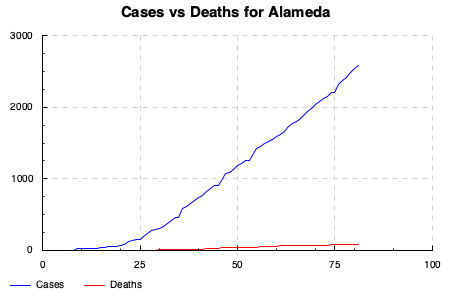

In [14]:
countyChart "Alameda"